<a href="https://www.kaggle.com/code/sonujha090/dogs-vs-cats-pytorch?scriptVersionId=114239526" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [114]:
from fastai.vision.all import *

In [115]:
if not os.path.exists('data'):
    os.mkdir('data')

In [116]:
# %%time 
# !unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip -d data/

In [117]:
# %%time 
# !unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip -d data/

In [118]:
path = Path("data")
Path.BASE_PATH = path
path.ls()

(#2) [Path('train'),Path('test')]

In [119]:
(path/'train').ls()

(#25000) [Path('train/cat.11905.jpg'),Path('train/cat.10707.jpg'),Path('train/dog.9811.jpg'),Path('train/dog.9274.jpg'),Path('train/cat.11620.jpg'),Path('train/dog.3016.jpg'),Path('train/dog.9454.jpg'),Path('train/cat.5471.jpg'),Path('train/dog.3001.jpg'),Path('train/dog.8880.jpg')...]

In [120]:
one_img = (path/'train').ls()[0]
one_img.name.split('.')[0]

'cat'

In [121]:
def custom_splitter(train_name, valid_name, train_pct, valid_pct):
    def fn(name_list):
        train_idx, valid_idx = RandomSplitter(valid_pct=0.2, seed=42)(name_list)
        np.random.shuffle(train_idx)
        train_len = int(len(train_idx) * train_pct)
        valid_len = int(len(valid_idx)* valid_pct)
        return train_idx[0:train_len], valid_idx[0:valid_len]
    return fn

In [128]:
train_img_dir = path/'train'
label_fn = lambda x: x.name.split('.')[0]
images = get_image_files(train_img_dir)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=custom_splitter(train_name='training', valid_name='validation', train_pct=1, valid_pct=1),
    get_y=label_fn,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

# taking a subset of the data for faster training
dls = dblock.dataloaders(train_img_dir, bs=8)

In [129]:
print(f"Training dataset: {len(dls.train_ds)} Validation dataset: {len(dls.valid_ds)}")

Training dataset: 20000 Validation dataset: 5000


In [130]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

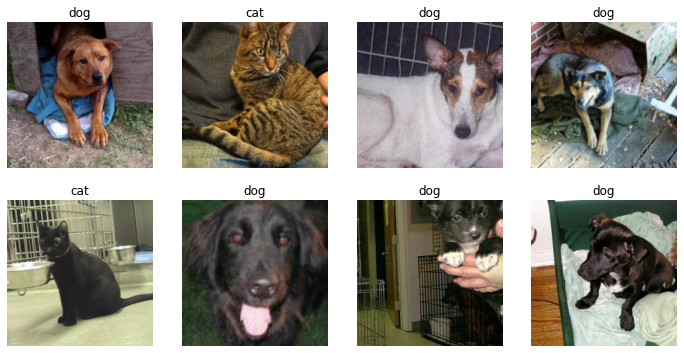

In [131]:
dls.show_batch()

In [132]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [133]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.253106,0.068286,0.027600,06:23


epoch,train_loss,valid_loss,error_rate,time
0,0.154469,0.039716,0.012400,06:35


# Model Interpretation

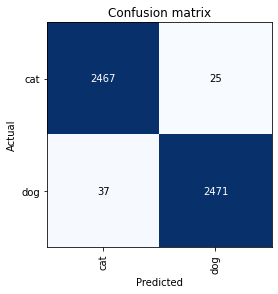

In [134]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [136]:
# predict
img = PILImage.create('data/test/1.jpg')
img.to_thumb(128,128)
learn.predict(img)

('dog', TensorBase(1), TensorBase([9.3627e-05, 9.9991e-01]))

# Prediction on test dataset

In [137]:
# creating test dataloader
test_dl = learn.dls.test_dl(get_image_files(path/'test'))

In [138]:
%%time
preds, _ = learn.get_preds(dl=test_dl)

CPU times: user 36.4 s, sys: 3.16 s, total: 39.5 s
Wall time: 2min 33s


In [139]:
# class 1 is the dog class and class 0 is the cat class
preds = preds[:,1]

(array([5945.,  151.,   65.,   56.,   38.,   47.,   41.,   94.,  225.,
        5838.]),
 array([9.79407559e-07, 1.00000665e-01, 2.00000361e-01, 3.00000042e-01,
        3.99999738e-01, 4.99999404e-01, 5.99999130e-01, 6.99998796e-01,
        7.99998462e-01, 8.99998188e-01, 9.99997854e-01], dtype=float32),
 <BarContainer object of 10 artists>)

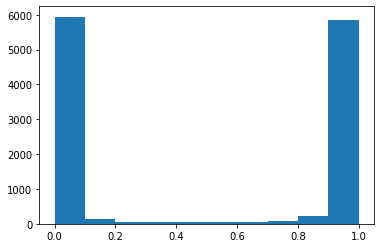

In [140]:
plt.hist(preds)

In [142]:
# creating the submission dataframe
submission_df = pd.DataFrame({'id': [int(x.stem) for x in test_dl.items], 'label': preds})
submission_df.head()

,id,label
0,8657,0.045542
1,1895,0.971265
2,10510,0.003263
3,5013,0.057003
4,4133,0.000757


In [143]:
# saving the submission dataframe
submission_df.to_csv('submission.csv', index=False)